<a href="https://colab.research.google.com/github/Zypher44/RaduIntuneric/blob/master/TransferLearningScalingUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer learning with Tensorflow, scaling up 

In [3]:
!nvidia-smi

Sat Jul 10 21:09:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Create helper functions 

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-10 21:09:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-10 21:09:15 (81.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
#Import series of helper functions from notebook 
from helper_functions import make_confusion_matrix, create_tensorboard_callback, plot_loss_curves, unzip_data,compare_historys,walk_through_dir


In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2021-07-10 21:09:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.253.62.128, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   191MB/s    in 6.8s    

2021-07-10 21:09:34 (229 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:



walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food

In [8]:
# set up data inputs 
import tensorflow as tf 

IMG_Size = (224,224)
print("train data")
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                               image_size=IMG_Size)
print("Test Data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_Size,
                                                                shuffle=False)

train data
Found 7575 files belonging to 101 classes.
Test Data
Found 25250 files belonging to 101 classes.


#Training a big model :

*create a model checkpoint callback 
*Create a data augmentation layer to build data augmentation into the model 
*Build a headless (no top layers) functional EfficentnetB0 backboned model (create our own input layer)
*Compile the model 
*Feature extract for 5 full passes (5 epochs on train dataset, validate on 15% of the test data)


In [9]:
#Create checkpont callback 

checkpoing_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoing_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

#Creating data augmentation layer 

In [10]:

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


#Setup data augmentation 

data_augmentation = tf.keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2)
     # preprocessing.Rescaling(1./255) # Can skip when using EfficentnetB0, some other models may need to be rescaled tho

],name='data_Augmentation')

In [11]:
 #Setup basemodel and frezze its layers (This exctract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False) #Dont want top layers
base_model.trainable=False #Freeze all the patterns EfficentNetB0 has learned 

 #Setup model architecutre with trainable top layers 

inputs = layers.Input(shape=(224,224,3), name='Input_layer')
x = data_augmentation(inputs) #Augment images (only happens during traing phase) this a model so x goes inside brackets
x = base_model(x,training=False) # training false puts model in inferance mode so frozen weights stay frozen this a model so x goes inside brackets
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs= layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax',name='output_layer')(x)


model = tf.keras.Model(inputs,outputs)


16711680/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_Augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data= test_data,
    validation_steps = int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 120s 360ms/step - loss: 3.4766 - accuracy: 0.2432 - val_loss: 2.7207 - val_accuracy: 0.3914
Epoch 2/5
237/237 [==============================] - 69s 290ms/step - loss: 2.3479 - accuracy: 0.4606 - val_loss: 2.2790 - val_accuracy: 0.4526
Epoch 3/5
237/237 [==============================] - 65s 273ms/step - loss: 1.9786 - accuracy: 0.5370 - val_loss: 2.0864 - val_accuracy: 0.4772
Epoch 4/5
237/237 [==============================] - 58s 245ms/step - loss: 1.7663 - accuracy: 0.5729 - val_loss: 1.9963 - val_accuracy: 0.4873
Epoch 5/5
237/237 [==============================] - 58s 244ms/step - loss: 1.6055 - accuracy: 0.6054 - val_loss: 1.9639 - val_accuracy: 0.4905


In [15]:
#Evaluate on the whole test set now 

feature_exctaction_results = model.evaluate(test_data)

790/790 [==============================] - 87s 111ms/step - loss: 1.6986 - accuracy: 0.5587


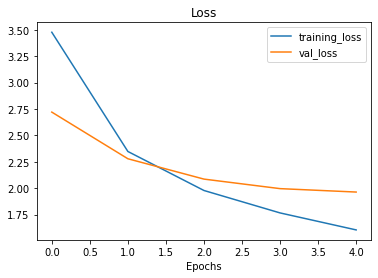

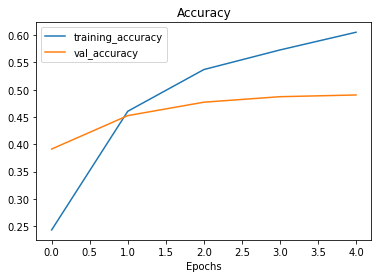

In [16]:
plot_loss_curves(history)

In [17]:
#Data is currently overfitting on our model 



#Fine Tuning 

In [18]:
#Unfreeze all the layers in the basemodel 

base_model.trainable=True

#Refreeze every layer execpt the last 5

for layer in base_model.layers[:-5]:
  layer.trainable =False

In [19]:
#Recompile model with lower learning rate (best practice to lower LR by 10x)
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

In [20]:
#what layers in the model are trainable ?

for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_Augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
#Check which layers are trainable in our basemodel 

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
#Last 5 are trainable !!!! 

#Fine tune for 5 more epochs 

fine_tune_epochs = 10 #Model has already done 5 epochs (feature exctraction)

#Fine tune model 

history_all_classes_fine_tune = model.fit(train_data_all_10_percent,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps = int(0.15*len(test_data)),
                                          initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 63s 239ms/step - loss: 1.3552 - accuracy: 0.6550 - val_loss: 1.9073 - val_accuracy: 0.5021
Epoch 6/10
237/237 [==============================] - 54s 228ms/step - loss: 1.2229 - accuracy: 0.6826 - val_loss: 1.9525 - val_accuracy: 0.4958
Epoch 7/10
237/237 [==============================] - 54s 227ms/step - loss: 1.1451 - accuracy: 0.6987 - val_loss: 1.9202 - val_accuracy: 0.5058
Epoch 8/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0745 - accuracy: 0.7178 - val_loss: 1.8963 - val_accuracy: 0.5154
Epoch 9/10
237/237 [==============================] - 51s 215ms/step - loss: 1.0188 - accuracy: 0.7283 - val_loss: 1.8445 - val_accuracy: 0.5238
Epoch 10/10
237/237 [==============================] - 50s 211ms/step - loss: 0.9708 - accuracy: 0.7468 - val_loss: 1.8833 - val_accuracy: 0.5159


In [23]:
model.evaluate(test_data)

790/790 [==============================] - 87s 110ms/step - loss: 1.5930 - accuracy: 0.5823


[1.593047857284546, 0.5822970271110535]

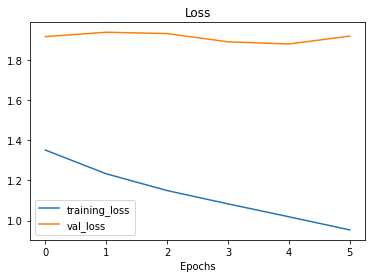

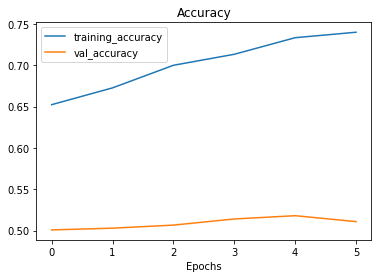

In [22]:
plot_loss_curves(history_all_classes_fine_tune)

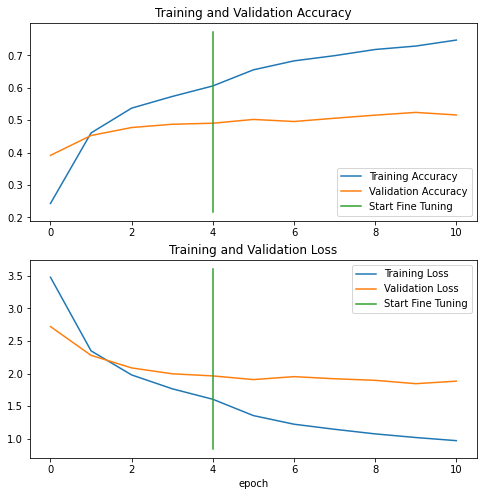

In [24]:
compare_historys(original_history=history, new_history=history_all_classes_fine_tune,
                 initial_epochs=5)

##Save and load our model 

In [25]:
model.save("drive/MyDrive/Colab Notebooks")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/assets


In [26]:
#Load model 
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks")

In [27]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 89s 111ms/step - loss: 1.5930 - accuracy: 0.5823


[1.593047857284546, 0.5822970271110535]

#Evaluating performance of model across all diffierent classes and find out which perdicitons where most wrong

In [28]:
#Download pretrained model 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-10 21:34:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   217MB/s    in 0.2s    

2021-07-10 21:34:00 (217 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [30]:
#Load in saved model 

model2 = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [31]:
model_2_results = model2.evaluate(test_data)

790/790 [==============================] - 92s 115ms/step - loss: 1.8027 - accuracy: 0.6078


#Making perdicitons with our trained model

In [32]:
pred_probs = model2.predict(test_data,verbose=1)

790/790 [==============================] - 64s 80ms/step


In [33]:

#How many perdicitons are there
len(pred_probs)

25250

In [34]:
pred_probs.shape

(25250, 101)

In [35]:
 sum(pred_probs[1])

0.9999999599586559

In [36]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes


array([ 52,   0,   0, ..., 100,  94, 100])

In [37]:
len(pred_classes)

25250

To evaluate perdicitons we need to compare them to the original test dataset

In [38]:
 #Unravel our test_Data batchdataset
 y_labels= []

 for images,labels in test_data.unbatch():
   y_labels.append(labels.numpy().argmax())
y_labels[:10]#Look at first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
len(y_labels)

25250

##Evaluating our model's perdicitons 
One way to check if model's perdictions array is in the same order is to find the accuracy score 

---



In [39]:
model_2_results

[1.8027206659317017, 0.6077623963356018]

In [40]:
#lets try scikit-learns accuracy score and see what comes up 
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.6077623762376237

 #Make a confusion Matrix 

*   List item
*   List item



In [41]:
#Get a list of classnames 

class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

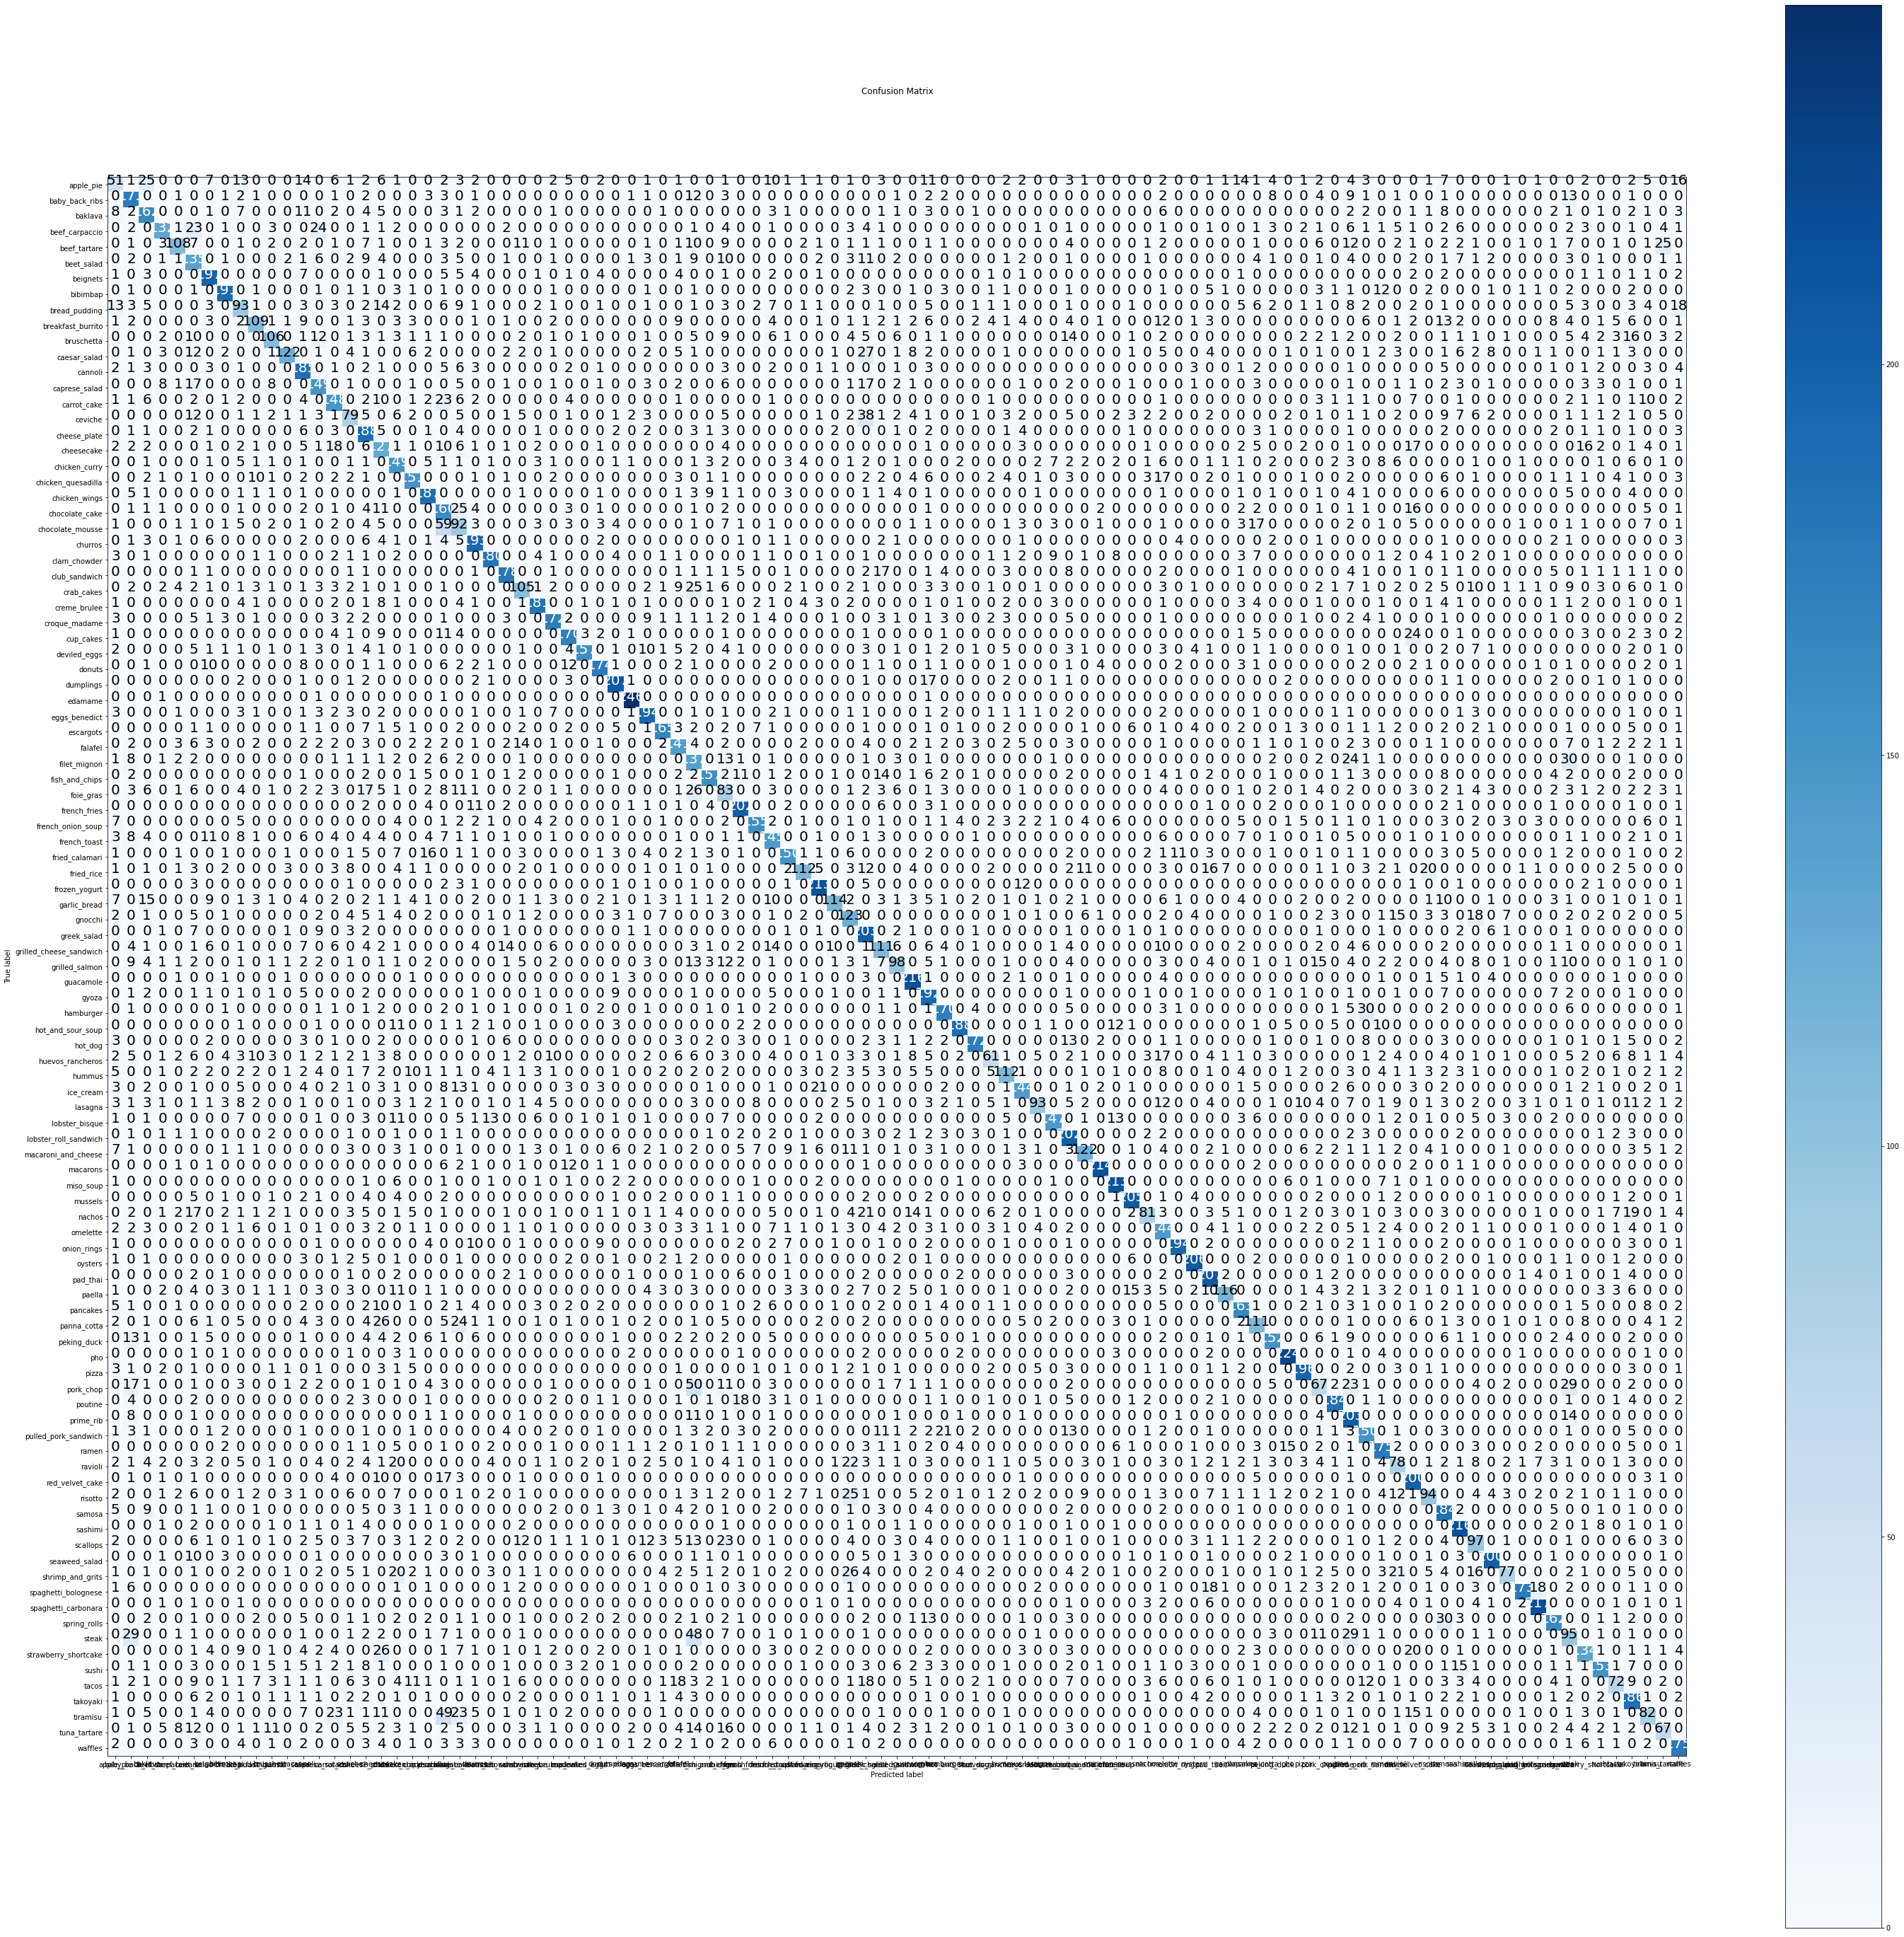

In [42]:
make_confusion_matrix(y_true=y_labels,y_pred=pred_classes,classes=class_names,
                      figsize=(50,50),
                      text_size=20,
                      )

#Have to edit function to make x axis names to appear vertical 

In [43]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix1(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusio
    n matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ##Change plot labels vertically
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)

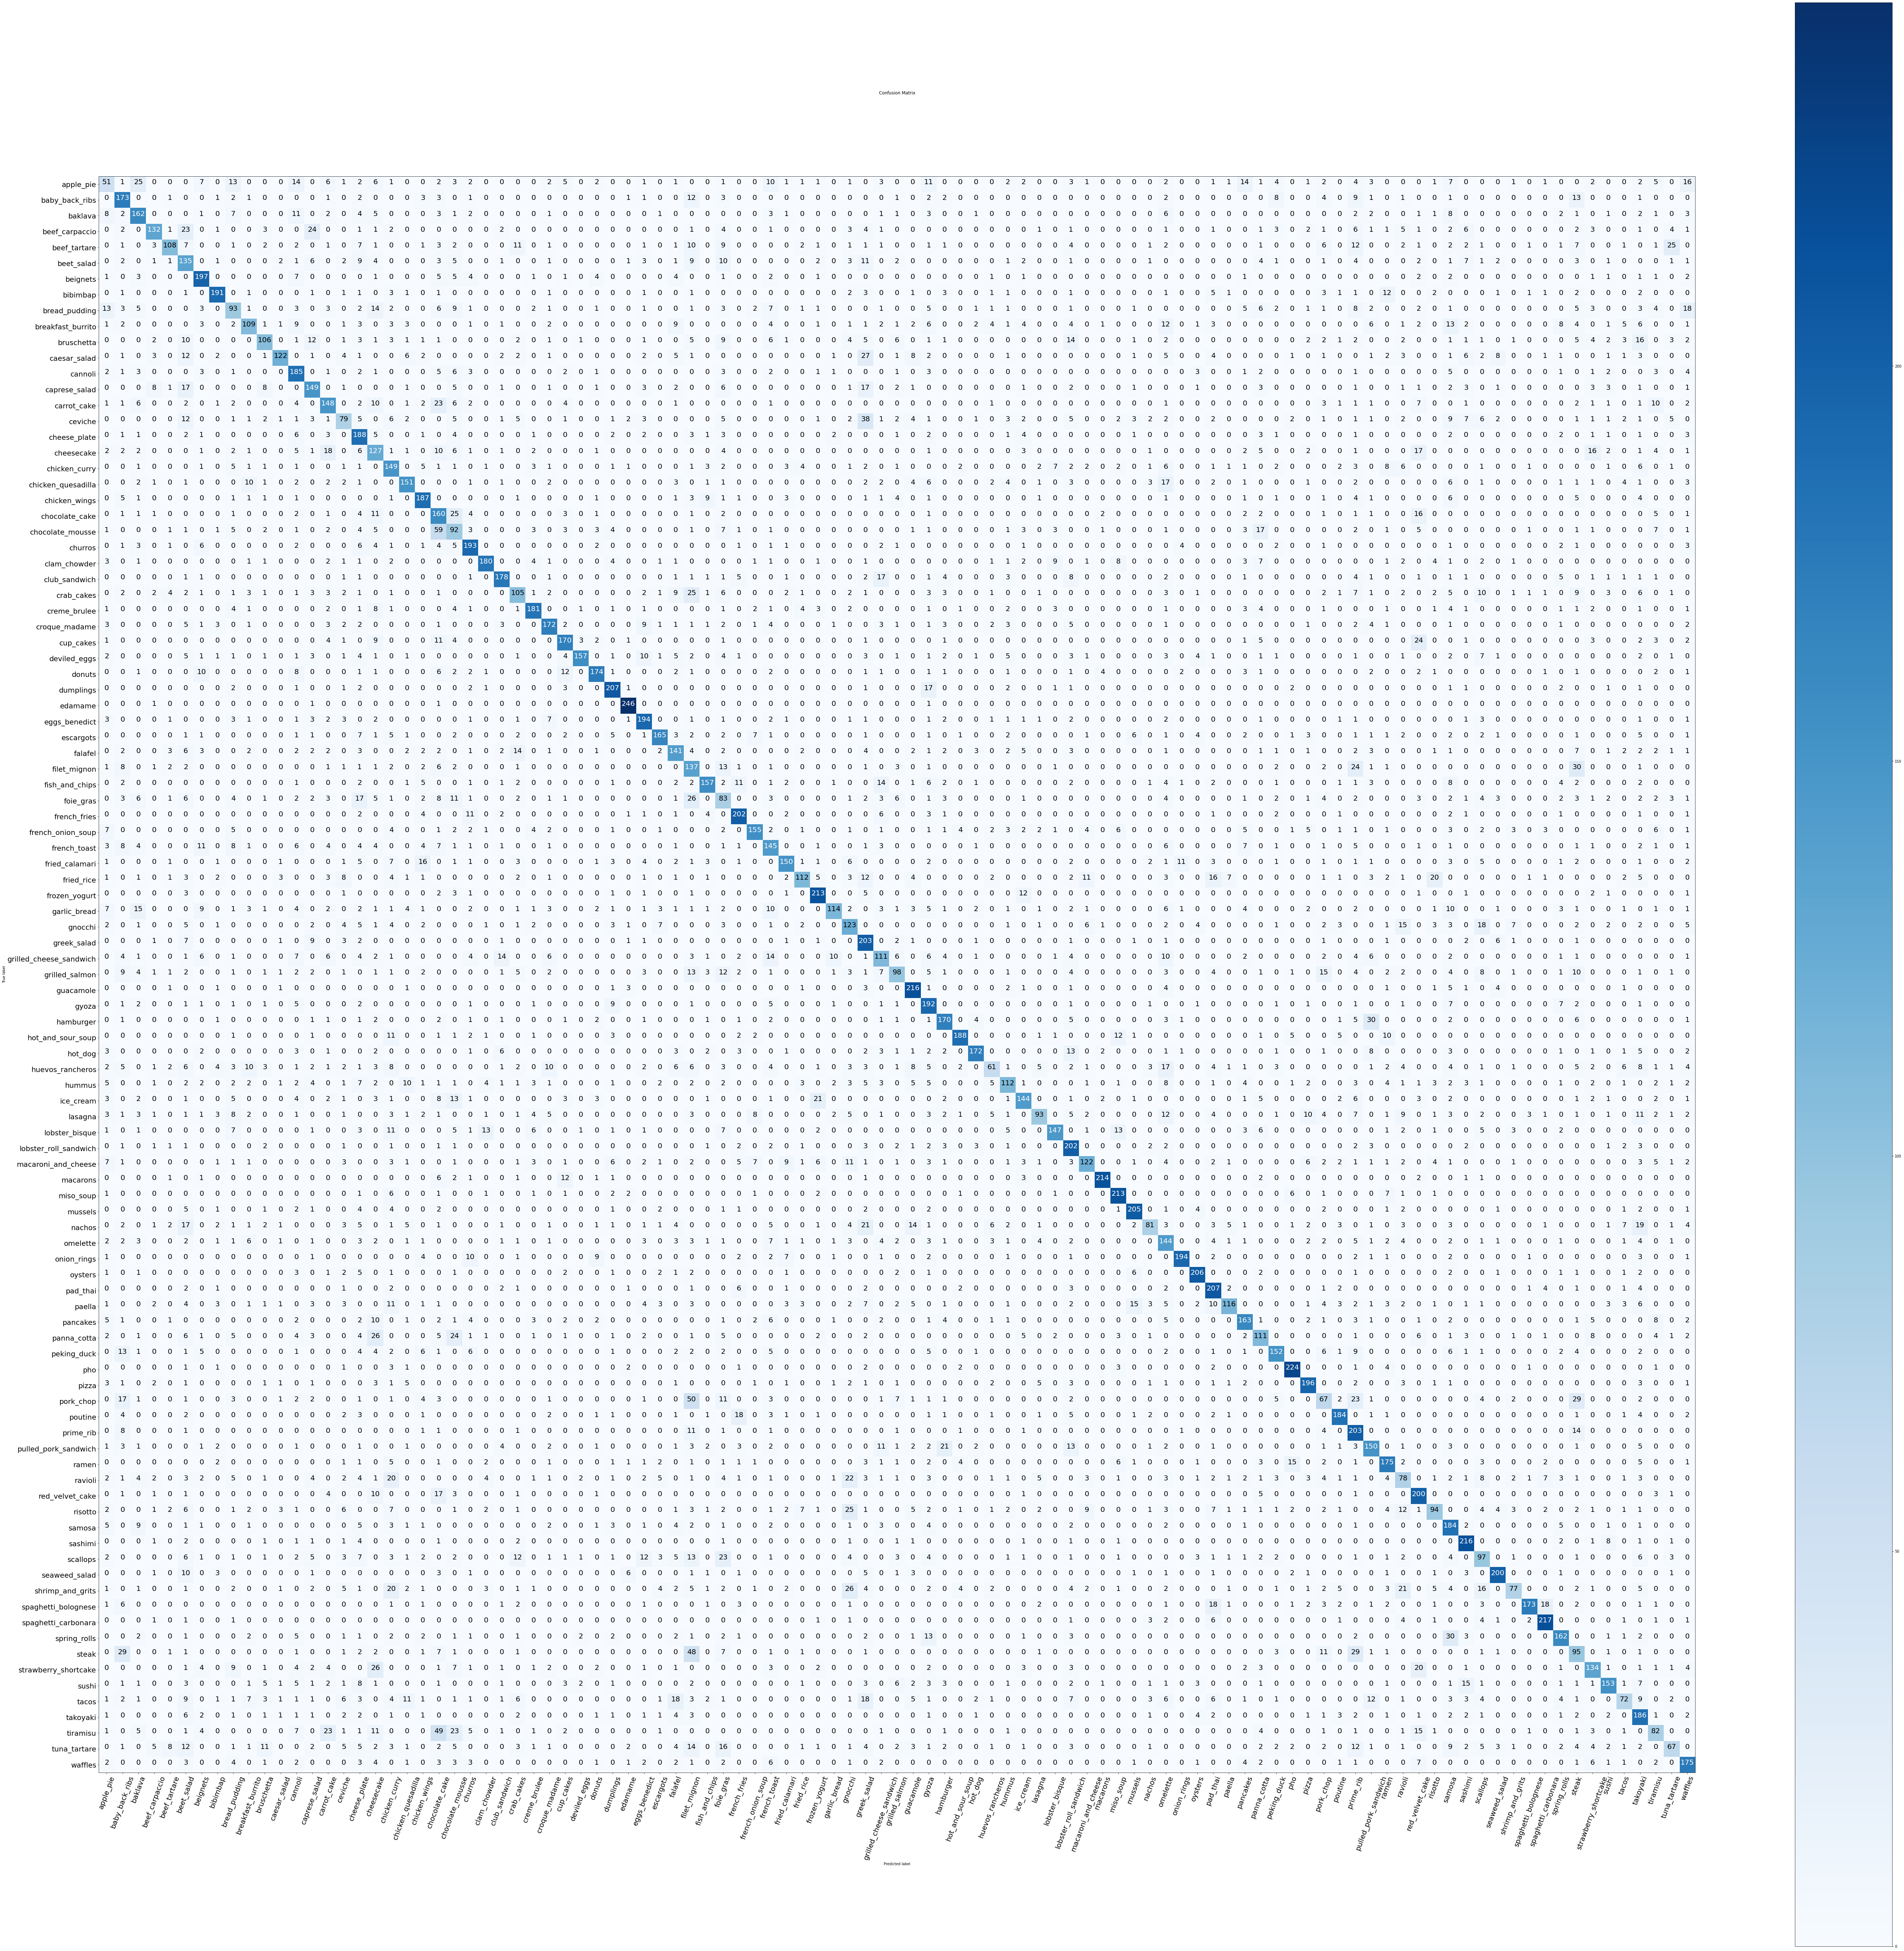

In [44]:
make_confusion_matrix1(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

#Classification Report 

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

#Classification evaluation methods 

1.   Percision = Higher percision leads to less false postivies 

2.   Recall = Higher recall leads to less false negatives 
3.   F1-score = Combination of percision and recall usually a good overall metric for a classification model 







In [46]:
#Get a dict of classificaion report 
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)

In [47]:
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Lets plot all our classes f1 score 

In [48]:
class_f1_scores = {}
#Loop through classificaiton report dicitironary items 
for k , v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
   break
  else:
    #add names and f1-scores to new dictironayh 
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [49]:
#Turn f1 scores into Dataframe for visulation

import pandas as pd 

f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1_score":list(class_f1_scores.values())}).sort_values("f1_score",ascending=False)

f1_scores[:-10]

class_names  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

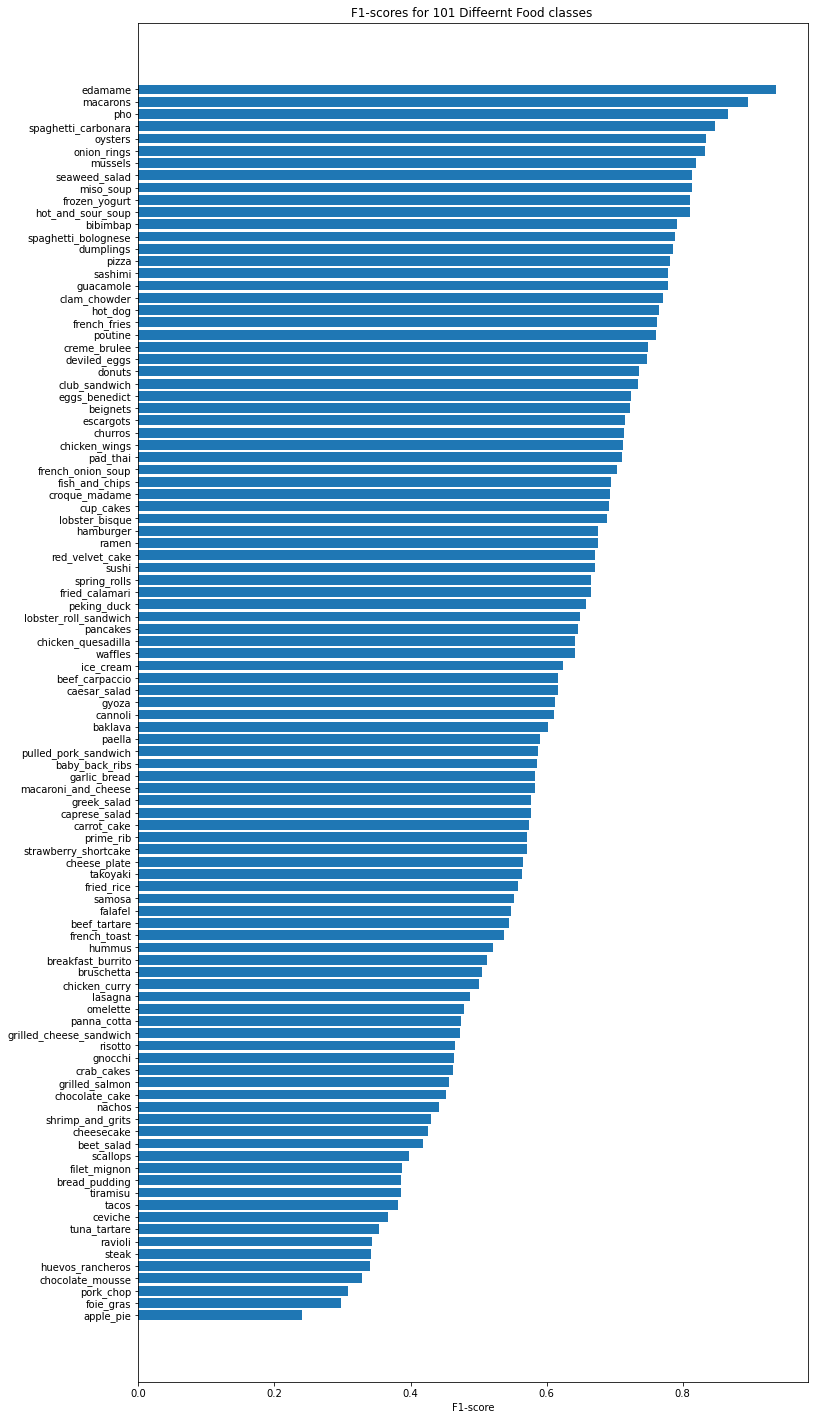

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1_score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Diffeernt Food classes ")
ax.invert_yaxis() #Reverse order of the plot 


In [51]:
 def load_and_prep_image(filename, img_shape=224, scale=True):
   """
   Reads in an image from filename, turns it into a tensor and reshapes into specified shape

   Returns:
   Image tesnor of shape (img_shape, )
   """
   img = tf.io.read_file(filename)

   #Decode image into tensors 

   img = tf.io.decode_image(img, channels=3)

   #Resize image 

   img = tf.image.resize(img,[img_shape,img_shape])

   #Scale Yes/No 
   if scale:
     #Rescale the image (Get values between 0 and 1 )
      return img/225.
   else:
      return img #Dont need to rescale for efficent net models 




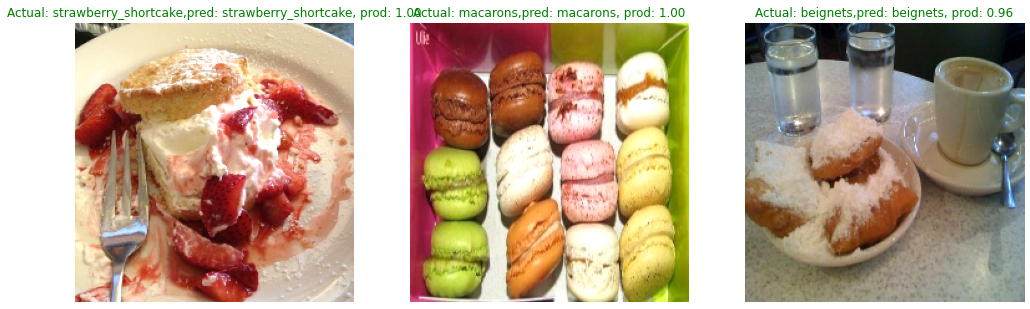

In [52]:
import os 
import random 

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename= random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
  #print(filepath)

  #Load image and make perdcitons 

  img = load_and_prep_image(filepath, scale=False)
  #print(img.shape)
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model2.predict(img_expanded)#Get perdcition proabilite array 
  pred_class = class_names[pred_prob.argmax()]
  #print(pred_probs)
  #print(pred_classes)

  #Plot the images 

  plt.subplot(1,3, i+1)
  plt.imshow(img/225.)
  if class_name == pred_class: #If predicted class matchs truth class
    title_color= "g"
  else:
    title_color = 'r'
  plt.title(f"Actual: {class_name},pred: {pred_class}, prod: {pred_prob.max():.2f}",c=title_color)
  plt.axis(False);


#Finding the most wrong perdicitons 

In [53]:
#Get filepaths from the dataset

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [54]:
#Create a DataFrame of differnet paramaters for each of our test images 

import pandas as pd 
pred_df = pd.DataFrame({'img_path':filepaths,
                        "y_true": y_labels,
                        'y_pred':pred_classes,
                        "pred_conf":pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classnames":[class_names[i] for i in pred_classes]})
pred_df

img_path  ...     y_pred_classnames
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [55]:
#Find out from our DataFrame which perdictions are correct 

pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']

pred_df['pred_correct'].head()

0    False
1     True
2     True
3    False
4    False
Name: pred_correct, dtype: bool

In [56]:
#Sort our dataframe to have the most wrong perdictions at the top 

top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
...                                                  ...  ...           ...
8763   b'/content/101_food_classes_10_percent/test/es...  ...         False
2663   b'/content/101_food_classes_10_percent/test/br...  ...         False
7924   b'/content/101_food_classes_10_percent/test/do...  ...         False
18586  b'/content/101_food_classes_10_percent/test/pe...  ...         False
3519   b'/content/101_food_classes_10_percent/test/ca...  ...         False

[100 rows x 7 columns]

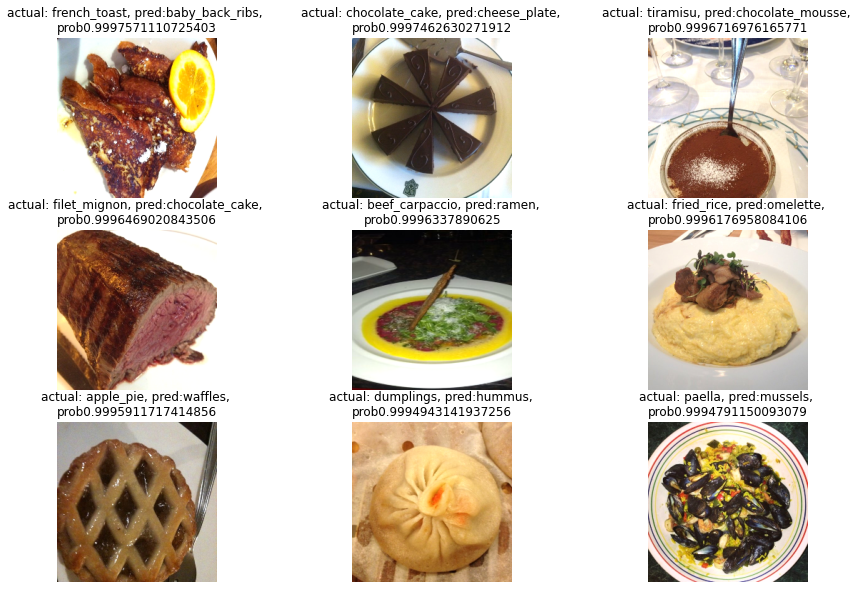

In [64]:
#Visulaize the test data samples 
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row # Only intreseted in a few paramaters
  plt.imshow(img/225.)
  plt.title(f"actual: {y_true_classname}, pred:{y_pred_classname}, \nprob{pred_prob}")
  plt.axis(False);
   


#Test model on custom images 



In [100]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-07-10 22:09:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.06s   

2021-07-10 22:09:37 (209 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [101]:
custom_food_images = ["custom_food_images/" +img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

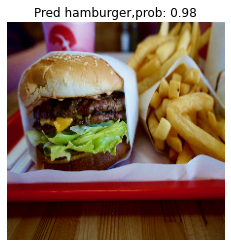

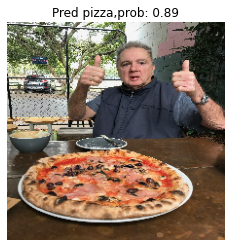

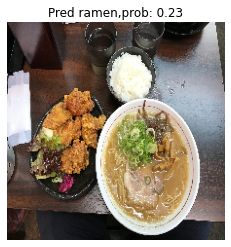

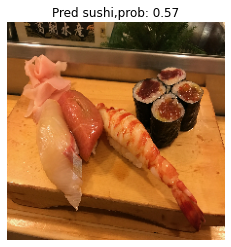

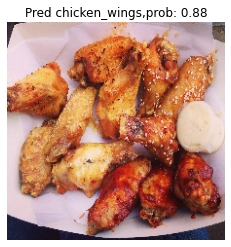

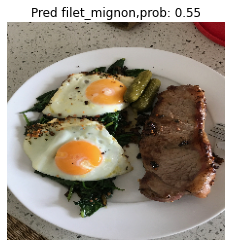

In [102]:
#Make predictions and plot on the image 

for img in custom_food_images:
  img = load_and_prep_image(img,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]

  #Plot the appropriate information 
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred {pred_class},prob: {pred_prob.max():.2f}")
  plt.axis(False)
